In [61]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from gensim import corpora
from gensim import similarities
from string import punctuation
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, nmf, LdaMulticore
import spacy
# you need to run python -m spacy download en
import nltk
from nltk import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import pyLDAvis.gensim
from wordcloud import WordCloud
pyLDAvis.enable_notebook()
import warnings, sys, traceback, itertools, collections, logging
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

#pd.set_option('display.max_colwidth', -1)

In [3]:
print("Start the topic modelling discover ...")
t_total = time()

Start the topic modelling discover ...


Configuraciones del logging

In [4]:
FORMAT = '%(asctime)-15s - %(filename)s:%(lineno)s - %(funcName)20s() \n%(message)s'
logging.basicConfig(filename='./topic_modelling.log', filemode='w', level=logging.ERROR, format=FORMAT)
logger = logging.getLogger(__name__)

In [5]:
#agregue mas bad_ids
nltk.download('stopwords')
stop_words = stopwords.words('english')
bad_ids=['like','say','remember','dream','think','know','could','go','would','want','tell','thing','start','come','back','look','people','ask','seem','talk','make','take', 'recall', 'try', 'get', 'see', 'put']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Estefi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Configuraciones generales

In [62]:
#agregue star,limit,step
data_directory = '../data'
from_file = True
experiment = 3
limit=101; start=20; step=5;
number_of_topics_list = np.arange(start,limit,step)
num_topics=25

In [63]:
summary = pd.read_csv(f'{data_directory}/dreamers_summary.csv', sep='|')
dream = pd.read_csv(f'{data_directory}/dreams_clean.csv', sep=';')
# Borro aquellos sueños que no tienen palabras y aquellos en aleman que son los del grupo con id 18, 26 y 27
dream = dream.dropna(axis=0, subset=['words']).drop(dream.loc[dream['group_id'].isin([18, 26, 27, 79, 80])].index)


In [64]:
df = pd.merge(dream, summary, left_on='group_id', right_on='id')

In [65]:
data = df['description'].values.tolist()

In [14]:
def sent_to_words(sentences, word_min_len=2):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=word_min_len))  # deacc=True removes punctuations

In [15]:
#agregue en la ultima linea -> and word not in bad_ids
def process_words(texts, stop_words, bigram_mod, trigram_mod, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], word_min_len=2, bad_ids = []):
    """Remove Stopwords, Form Bigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc), min_len=word_min_len) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    #texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), min_len=word_min_len) if word not in stop_words and word not in bad_ids] for doc in texts_out]    
    return texts_out

In [16]:
#agregue concatenacion con los sueños, su id, su categorizacion.
def format_topics_sentences(model, corpus, texts, n_words):
    dominant_topics_df = pd.DataFrame()
    for topic_distribution in model[corpus]:
        sorted_topics = sorted(topic_distribution[0], key=lambda x: (x[1]), reverse=True)
        try:
            topic_number, topic_prob = sorted_topics[0]
            topic_first_n_words = ", ".join([word for word, prob in model.show_topic(topic_number, topn=n_words)])
            dominant_topics_df = dominant_topics_df.append(pd.Series([topic_number, topic_prob, topic_first_n_words]), ignore_index=True)
        except:
            dominant_topics_df = dominant_topics_df.append(pd.Series([None, None, None]), ignore_index=True)
            logger.error('%s', traceback.format_exc())

    topics_df = pd.concat([dominant_topics_df, df[['code','note','group_id','group','dreamer sex','dreamer age','dream years','description']]], axis=1)
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'code','note','group_id','group','dreamer sex','dreamer age','dream years','description']
    
    return(topics_df)

In [18]:
#agregue print de tamaño corpus.
print("Yielding the words ...")
t0 = time()
data_words = list(sent_to_words(data))
print("El corpus tiene ",len(data_words), " sueños y ",sum([len(x) for x in data_words])," tokens"   )
print(f"... done in {time() - t0}s.")

Yielding the words ...
El corpus tiene  36202  sueños y  5560412  tokens
... done in 36.88537335395813s.


In [19]:
#agregue min_count=10, threshold=0.5, scoring='npmi
print("Generating bigram and trigram ...")
t0 = time()
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=0.5, scoring='npmi') # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
print(f"... done in {time() - t0}s.")

Generating bigram and trigram ...
... done in 44.80200457572937s.


In [20]:
#agregue print de tamaño corpus.
print("Pre processing words: remove stopwords, form Bigrams and Lemmatization ...")
t0 = time()
data_ready = process_words(data_words, stop_words, bigram_mod, None, word_min_len=3, bad_ids=bad_ids)
print("El corpus tiene ",len(data_ready), " sueños y ",sum([len(x) for x in data_ready])," tokens,bigramas,lemas"   )
print(f"... done in {time() - t0}s.")

Pre processing words: remove stopwords, form Bigrams and Lemmatization ...
El corpus tiene  36202  sueños y  1639031  tokens,bigramas,lemas
... done in 450.22242975234985s.


In [21]:
print("Creating dictionary and corpus ...")
t0 = time()
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
print(f"Length of the dictionary is {len(id2word)}")

print("Filtering the extremes no_below=10, no_above=0.5 ...")
id2word.filter_extremes(no_below=10, no_above=0.5)
print(f"Length of the filter dictionary is {len(id2word)}")

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
print(f"... done in {time() - t0}s.")

Creating dictionary and corpus ...
Length of the dictionary is 25149
Filtering the extremes no_below=10, no_above=0.5 ...
Length of the filter dictionary is 7342
... done in 9.076802968978882s.


In [16]:
#agregue chunksize=1000,iterations=1000,
if not from_file:
    print("Applying LDA topic modelling ...")
    t0 = time()
    lda_model_dict = {}
    for num_topics in number_of_topics_list:
        print(f"Looking for {num_topics} topics ...")
        t1 = time()
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    workers=5,
                                                    id2word=id2word,
                                                    num_topics=num_topics, 
                                                    random_state=100,
                                                    chunksize=1000,
                                                    iterations=1000,
                                                    passes=10,
                                                    per_word_topics=True)
        lda_model_dict[num_topics] = lda_model
        print(f"... done in {time() - t1}s for {num_topics} topics.")

    print(f"... all done in {time() - t0}s.")

    for num_topics, model in lda_model_dict.items():
        model.save(f"{data_directory}/models/lda_topics_{num_topics}_exp_{experiment}")

Applying LDA topic modelling ...
Looking for 20 topics ...
... done in 230.39974212646484s for 20 topics.
Looking for 25 topics ...
... done in 227.71212124824524s for 25 topics.
Looking for 30 topics ...
... done in 224.63752055168152s for 30 topics.
Looking for 35 topics ...
... done in 256.01119089126587s for 35 topics.
Looking for 40 topics ...
... done in 265.2979414463043s for 40 topics.
Looking for 45 topics ...
... done in 262.0571839809418s for 45 topics.
Looking for 50 topics ...
... done in 254.53572726249695s for 50 topics.
Looking for 55 topics ...
... done in 252.70406889915466s for 55 topics.
Looking for 60 topics ...
... done in 255.53284978866577s for 60 topics.
Looking for 65 topics ...
... done in 270.9566864967346s for 65 topics.
Looking for 70 topics ...
... done in 274.55688428878784s for 70 topics.
Looking for 75 topics ...
... done in 360.30224084854126s for 75 topics.
Looking for 80 topics ...
... done in 477.2715919017792s for 80 topics.
Looking for 85 topics 

Coherence total for 20 topics 0.47520726868618174
Coherence total for 25 topics 0.4610679518541439
Coherence total for 30 topics 0.479839782927882
Coherence total for 35 topics 0.46074033402242376
Coherence total for 40 topics 0.44070580120275515
Coherence total for 45 topics 0.44797700283429776
Coherence total for 50 topics 0.4495458599823128
Coherence total for 55 topics 0.4465343860700316
Coherence total for 60 topics 0.42602982537685535
Coherence total for 65 topics 0.43650105011710744
Coherence total for 70 topics 0.42423755506507127
Coherence total for 75 topics 0.40558411979626213
Coherence total for 80 topics 0.40843854342880437
Coherence total for 85 topics 0.4103475170113279
Coherence total for 90 topics 0.41041242448828946
Coherence total for 95 topics 0.4025262320403324
Coherence total for 100 topics 0.4141922346828679


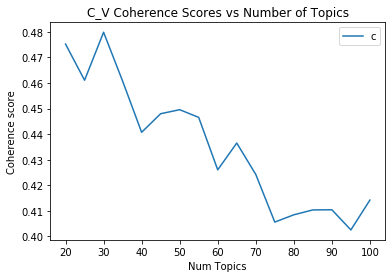

In [17]:
#agregue C_V coherence
coherence_values = []
for num_topics in number_of_topics_list:
    cm = CoherenceModel(model=lda_model_dict[num_topics], texts=data_ready, dictionary=id2word, coherence='c_v',topn=10)
    coherence_values.append(cm.get_coherence())
    print(f"Coherence total for {num_topics} topics {cm.get_coherence()}")

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_npmi"), loc='best')
plt.title("C_V Coherence Scores vs Number of Topics")
plt.show()

Coherence total for 20 topics 0.05224246168149832
Coherence total for 25 topics 0.049086847259697454
Coherence total for 30 topics 0.05501753837803044
Coherence total for 35 topics 0.04694551409382049
Coherence total for 40 topics 0.03955387199271894
Coherence total for 45 topics 0.03510507130415115
Coherence total for 50 topics 0.03352469179195788
Coherence total for 55 topics 0.031377133521177276
Coherence total for 60 topics 0.024616085147255853
Coherence total for 65 topics 0.027802231154515734
Coherence total for 70 topics 0.017991975493063906
Coherence total for 75 topics 0.006765714606547504
Coherence total for 80 topics 0.00920988147531841
Coherence total for 85 topics 0.010371046828372978
Coherence total for 90 topics 0.0037215922921205007
Coherence total for 95 topics 0.0004235143085386511
Coherence total for 100 topics -0.0010845284322210087


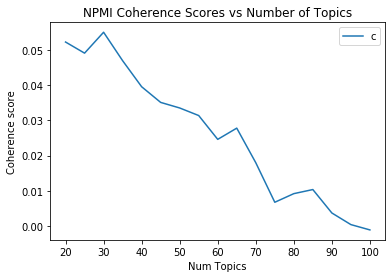

In [18]:
#agregue npmi coherence
coherence_values_npmi = []
for num_topics in number_of_topics_list:
    cm=CoherenceModel(model=lda_model_dict[num_topics], texts=data_ready, dictionary=id2word, window_size=30,coherence='c_npmi',topn=10)
    coherence_values_npmi.append(cm.get_coherence())
    print(f"Coherence total for {num_topics} topics {cm.get_coherence()}")

x = range(start, limit, step)
plt.plot(x, coherence_values_npmi)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values_npmi"), loc='best')
plt.title("NPMI Coherence Scores vs Number of Topics")
plt.show()

In [7]:
#num_topics topicos
num_topics=25

In [20]:
#agregue
#Coherence de cada topico encontrado para num_topics topicos
ldatopics = [[word for word, prob in topic] for topicid, topic in lda_model_dict[num_topics].show_topics(num_topics,formatted=False)]
lda_coherence = CoherenceModel(topics=ldatopics, texts=data_ready, dictionary=id2word, window_size=30,coherence='c_npmi',topn=10).get_coherence_per_topic()
df_lda = pd.DataFrame([range(num_topics),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()
pd.set_option("max_colwidth", 100)
pd.set_option('display.max_rows', 100)
df_lda.sort_values(by='coherence',ascending=False)[:num_topics]

,topic_id,coherence,topic
22,22,0.137371,"[wear, clothe, bathroom, shirt, shoe, dress, toilet, pant, clean, pair]"
7,7,0.106234,"[car, run, drive, road, plane, gun, fly, shoot, stop, hit]"
15,15,0.0960517,"[play, stage, music, game, show, name, audience, write, piano, singe]"
17,17,0.0926567,"[room, door, bed, open, sleep, leave, window, lock, bedroom, find]"
23,23,0.0817362,"[work, paper, computer, write, picture, different, word, information, page, use]"
20,20,0.0780465,"[car, drive, home, walk, way, road, truck, turn, street, right]"
6,6,0.0734824,"[mom, guy, girl, call, stuff, shop, school, place, later, friend]"
4,4,0.0699992,"[water, pool, fire, boat, swim, wave, walk, rock, little, big]"
9,9,0.0627634,"[run, tree, horse, jump, fall, dog, big, throw, ball, climb]"
12,12,0.0621645,"[phone, call, work, photo, office, find, computer, desk, time, number]"


In [8]:
if from_file:
    experiment = 3
    lda_model_dict = {}
    lda_model_dict[num_topics] = LdaModel.load(f"{data_directory}/models/lda_topics_{num_topics}_exp_{experiment}")
    print("Load succesfully")

Load succesfully


In [22]:
print("Calculating the distribution between topics and dreams ...")
t0 = time()
experiment=3
df_topic_sents_keywords = format_topics_sentences(model=lda_model_dict[num_topics], corpus=corpus, texts=data, n_words=10)
df_topic_sents_keywords.to_csv(f"{data_directory}/lda_topic_example_{num_topics}_exp_{experiment}.csv", sep=";", index=False)
print(f"... all done in {time() - t0}s.")

Calculating the distribution between topics and dreams ...
... all done in 479.93173480033875s.


In [ ]:
print("Calculating the distribution between topics and dreams ...")
t0 = time()
for num_topics, lda_model in lda_model_dict.items():
    t1 = time()
    print(f"Formating topics, corpus and saving them for lda model with {num_topics} topics ...")
    df_topic_sents_keywords = format_topics_sentences(model=lda_model, corpus=corpus, texts=data, n_words=10)
    df_topic_sents_keywords.to_csv(f"{data_directory}/lda_topic_example_{num_topics}_exp_{experiment}.csv", sep=";", index=False)
    print(f"... done in {time() - t1}s.")
print(f"... all done in {time() - t0}s.")

In [66]:
#agregue 
from_file = True
if from_file:
    df_topics=pd.read_csv(f"{data_directory}/lda_topic_example_{num_topics}_exp_{experiment}.csv", sep=";")  
    df_topics_by_dreams=pd.DataFrame(df_topics['Dominant_Topic'].value_counts())
    pd.set_option('display.max_rows', df.shape[0]+1)
    print("Topico numero ",num_topics)
    print("Sueños sin clasificar ",36202-df_topics_by_dreams['Dominant_Topic'].sum())
    print("Topicos clasificados ",df_topics_by_dreams['Dominant_Topic'].sum())
    print(df_topics_by_dreams)

Topico numero  25
Sueños sin clasificar  0
Topicos clasificados  36202
      Dominant_Topic
6.0             5391
14.0            2501
16.0            2314
24.0            2207
17.0            2062
7.0             1806
10.0            1585
20.0            1581
5.0             1577
9.0             1504
21.0            1480
11.0            1427
1.0             1365
18.0            1251
4.0              897
22.0             871
3.0              851
12.0             778
13.0             775
8.0              747
0.0              745
15.0             716
19.0             616
23.0             600
2.0              555


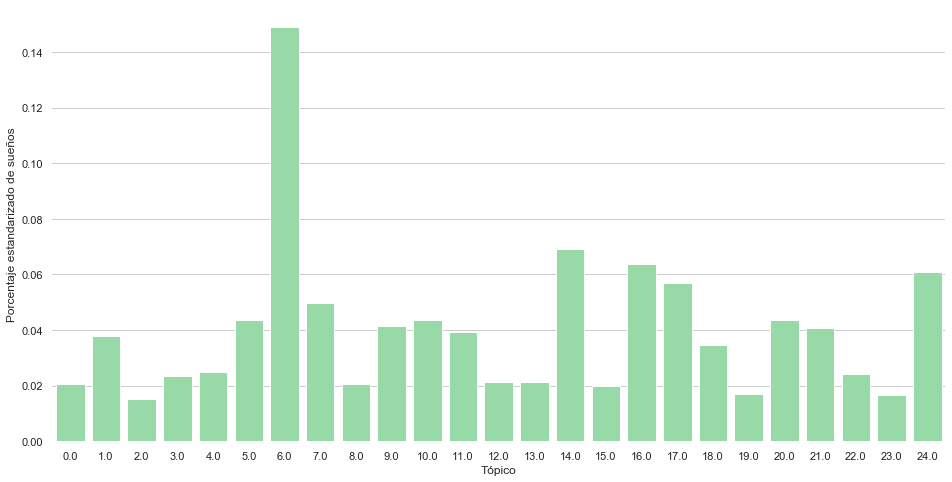

In [67]:
df_topics_by_dreams_normalize=df_topics_by_dreams/(df.shape[0]+1)
df_topics_by_dreams_normalize.rename(columns={'Dominant_Topic': 'count_normalize'}, inplace=True)

f, ax = plt.subplots(figsize=(16, 8))
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(df_topics_by_dreams_normalize.index,df_topics_by_dreams_normalize.count_normalize, color='g')
ax.set(ylabel="Porcentaje estandarizado de sueños", xlabel="Tópico")
sns.despine(left=True, bottom=True)

Text(0, 0.5, 'Dreams')

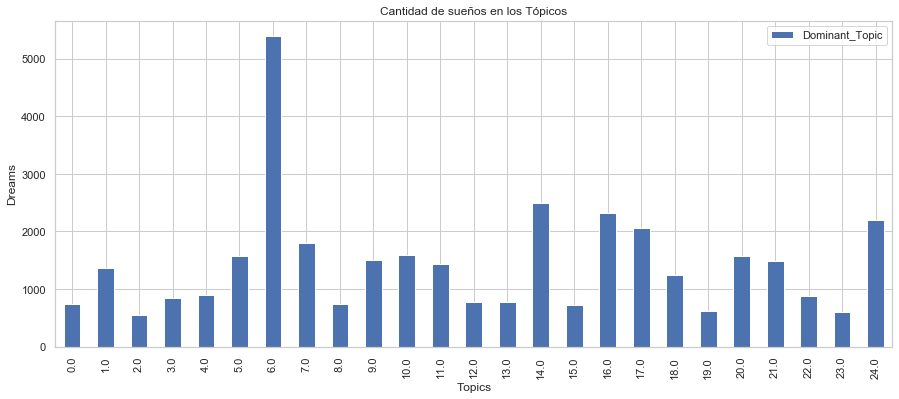

In [68]:
ax=df_topics_by_dreams.sort_index().plot(kind='bar', title='Cantidad de sueños en los Tópicos',figsize=(15, 6))
ax.set_xlabel("Topics")
ax.set_ylabel("Dreams")

In [172]:
topic_words=df_topics[['Dominant_Topic','Topic_Keywords']]
pd.set_option("max_colwidth", 80)
pd.set_option('display.max_rows', df.shape[0]+1)
topic_words=topic_words.drop_duplicates(['Dominant_Topic','Topic_Keywords']).sort_values(by="Dominant_Topic",ascending=True).reset_index()
topic_words['Label']=''
topic_words=topic_words[['Dominant_Topic','Label','Topic_Keywords']]
topic_words.at[0,'Label']='Undefined'
topic_words.at[1,'Label']='En Movimiento'
topic_words.at[2,'Label']='Películas'
topic_words.at[3,'Label']='Fiesta/Casamiento'
topic_words.at[4,'Label']='Deporte Acuático'
topic_words.at[5,'Label']='Colegio'
topic_words.at[6,'Label']='Amigos/Escuela/Adolescencia'
topic_words.at[7,'Label']='Accidente'
topic_words.at[8,'Label']='Trabajo'
topic_words.at[9,'Label']='Deporte al Aire Libre'
topic_words.at[10,'Label']='En Movimiento'
topic_words.at[11,'Label']='Relaciones Interpersonales'
topic_words.at[12,'Label']='Oficina'
topic_words.at[13,'Label']='Bebes'
topic_words.at[14,'Label']='Relaciones Interpersonalesr'
topic_words.at[15,'Label']='Entretenimiento'
topic_words.at[16,'Label']='Familia'
topic_words.at[17,'Label']='Dormitorio'
topic_words.at[18,'Label']='Perdida/Muerte'
topic_words.at[19,'Label']='Amigos/Escuela/Adolescencia'
topic_words.at[20,'Label']='Transporte'
topic_words.at[21,'Label']='Romance'
topic_words.at[22,'Label']='Vestimenta'
topic_words.at[23,'Label']='Trabajo'
topic_words.at[24,'Label']='Undefined'
df_style=topic_words.style.hide_index()
df_style.set_table_styles([ dict(selector='th', props=[("font-size", "150%"),("font-family", "Calibri"),('text-align', 'center')] ), dict(selector='td', props=[("font-size", "130%"),("font-family", "Calibri"),('text-align', 'left')] ) ])
df_style

Dominant_Topic,Label,Topic_Keywords
0,Undefined,"work, use, fish, job, test, need, also, different, time, ice"
1,En Movimiento,"sit, leave, walk, realize, door, room, stand, table, hand, right"
2,Películas,"movie, doctor, watch, group, film, episode, nurse, show, woman, move"
3,Fiesta/Casamiento,"friend, drink, walk, wedding, eat, bottle, snow, party, dress, find"
4,Deporte Acuático,"water, pool, fire, boat, swim, wave, walk, rock, little, big"
5,Colegio,"class, school, sit, teacher, student, room, next, walk, time, give"
6,Amigos/Escuela/Adolescencia,"mom, guy, girl, call, stuff, shop, school, place, later, friend"
7,Accidente,"car, run, drive, road, plane, gun, fly, shoot, stop, hit"
8,Trabajo,"man, light, small, large, group, team, building, long, bird, field"
9,Deporte al Aire Libre,"run, tree, horse, jump, fall, dog, big, throw, ball, climb"


In [ ]:
print("Calculating the coherence values ...")
t0 = time()
for num_topics, model in lda_model_dict.items():
    topics = [[word for word, prob in topic] for topicid, topic in model.show_topics(num_topics, formatted=False)]
    cm = CoherenceModel(topics=topics, texts=data_ready, dictionary=id2word, coherence='c_v',topn=10)
    #print(f"Coherende per topic {cm.get_coherence_per_topic()}")
    print(f"Coherence total for {num_topics} topics {cm.get_coherence()}")
print(f"... all done in {time() - t0}s.")

In [23]:
pyLDAvis.gensim.prepare(lda_model_dict[num_topics], corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.011206 -0.193339       1        1  8.494229
24    -0.053412 -0.057030       2        1  7.110940
14    -0.105359  0.135773       3        1  6.150649
16    -0.003822  0.083651       4        1  5.693413
17     0.073521 -0.028758       5        1  5.613225
10    -0.052248  0.062296       6        1  5.160544
1     -0.011275  0.049490       7        1  5.033421
7      0.178836 -0.094898       8        1  4.849720
20     0.002490 -0.017727       9        1  4.767948
21     0.151764  0.113403      10        1  4.258140
9      0.205923 -0.113299      11        1  4.068955
5     -0.090108 -0.042158      12        1  3.813757
11    -0.038463  0.098033      13        1  3.752563
18     0.080711  0.051698      14        1  3.431285
4      0.158551 -0.073452      15        1  3.076322
22     0.015778  0.101245      16        1  2.923615
8      0.130997  0.051202      17        1  2.807077
13     0.014243  0.071011      18        1  2.800423
12    -0.133845 -0.109577      19        1  2.775262
3      0.005878  0.079425      20        1  2.716832
15    -0.061002 -0.047387      21        1  2.527710
19    -0.032785 -0.038320      22        1  2.239850
0     -0.153216 -0.048746      23        1  2.050889
23    -0.190917 -0.065693      24        1  2.049437
2     -0.081033  0.033156      25        1  1.833799, topic_info=     Category          Freq             Term         Total  loglift  logprob
896   Default   9245.000000              mom   9245.000000  30.0000  30.0000
49    Default   9777.000000              car   9777.000000  29.0000  29.0000
31    Default   5752.000000             play   5752.000000  28.0000  28.0000
1492  Default   5462.000000            water   5462.000000  27.0000  27.0000
26    Default  11172.000000              man  11172.000000  26.0000  26.0000
279   Default   8239.000000              guy   8239.000000  25.0000  25.0000
32    Default  12587.000000             room  12587.000000  24.0000  24.0000
442   Default   3375.000000            class   3375.000000  23.0000  23.0000
14    Default   4827.000000            drive   4827.000000  22.0000  22.0000
402   Default   7307.000000             work   7307.000000  21.0000  21.0000
192   Default   7854.000000             door   7854.000000  20.0000  20.0000
383   Default   4714.000000              bed   4714.000000  19.0000  19.0000
300   Default   4765.000000           school   4765.000000  18.0000  18.0000
132   Default   8920.000000             girl   8920.000000  17.0000  17.0000
565   Default   2436.000000            movie   2436.000000  16.0000  16.0000
210   Default   7539.000000             kind   7539.000000  15.0000  15.0000
199   Default   7221.000000           friend   7221.000000  14.0000  14.0000
161   Default   8553.000000              run   8553.000000  13.0000  13.0000
91    Default   2436.000000             road   2436.000000  12.0000  12.0000
44    Default   7589.000000            woman   7589.000000  11.0000  11.0000
151   Default   1805.000000            phone   1805.000000  10.0000  10.0000
767   Default   2993.000000             wear   2993.000000   9.0000   9.0000
181   Default   3123.000000              boy   3123.000000   8.0000   8.0000
118   Default   6602.000000             call   6602.000000   7.0000   7.0000
169   Default   4780.000000            watch   4780.000000   6.0000   6.0000
2026  Default   1595.000000          teacher   1595.000000   5.0000   5.0000
780   Default   1360.000000            train   1360.000000   4.0000   4.0000
38    Default   9391.000000              sit   9391.000000   3.0000   3.0000
188   Default   1824.000000              die   1824.000000   2.0000   2.0000
2514  Default   2348.000000             game   2348.000000   1.0000   1.0000
2570   Topic1    273.224243           random    276.052490   2.4555  -6.2001
3887   Topic1     69.081703            siren     69.936394   2

In [24]:
print(f"... all the work was done in {time() - t_total}s.")

... all the work was done in 8417.271136522293s.


In [ ]:
long_string = ','.join(data_ready[2])# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

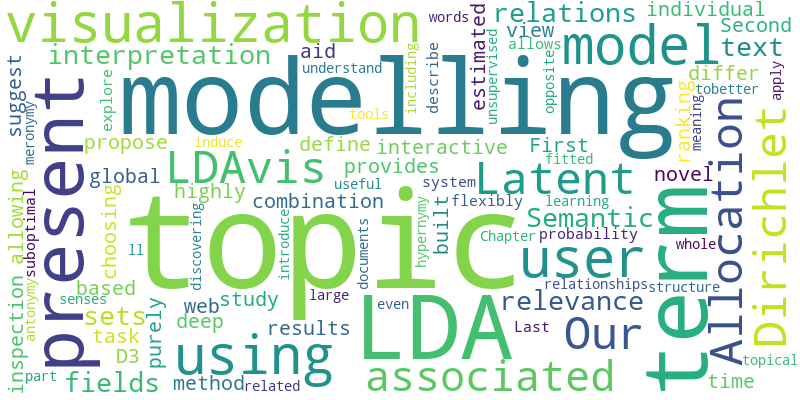

In [177]:
long_string ="We present LDAvis, a web-based interactive visualization of topics estimated using Latent Dirichlet Allocation that is built using a combination of R and D3. modelling modelling modelling modelling Our visualization provides a global view of the topics (and how they differ from each other), while at the same time allowing for a deep inspection of the terms most highly associated with each individual topic. First, we propose a novel method for choosing which terms to present to a user to aid in the task of topic interpretation, in which we define the relevance of a term to a topic. Second, we present results from a user study that suggest that ranking terms purely by their probability under a topic is suboptimal for topic interpretation. Last, we describe LDAvis, our visualization system that allows users to flexibly explore topic-term relationships using relevance tobetter understand a fitted LDA model. Semantic fields are also related to topic models, like Latent Dirichlet Allocation,LDA, which apply unsupervised learning on large sets of texts to induce sets of associated words from text. Semantic fields and topic models are very useful tools for discovering topical structure in documents. In Chapter 19 we’ll introduce even more relations between senses, including hypernymy or IS-A, antonymy (opposite meaning) and meronymy) (part-whole relations) topic modelling topic modelling topic modelling LDA LDA LDA"

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

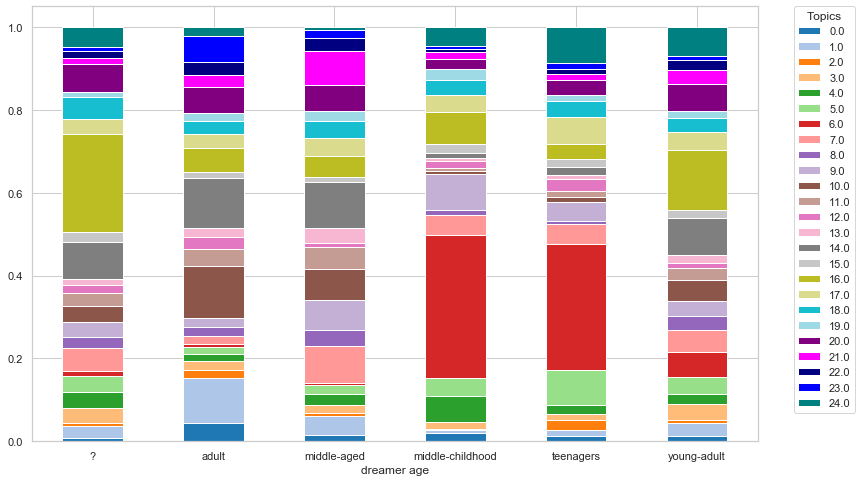

In [69]:
# Un solo grafico para todos los rangos etarios con su distribucion de topicos.
df_etario=df_topics[~df_topics['dreamer age'].isin(['series'])]
df_etario=df_etario.groupby(['dreamer age','Dominant_Topic']).agg({'Perc_Contribution': 'sum'})
df_etario=df_etario.unstack()['Perc_Contribution']
#normalizo 
df_etario = df_etario.div(df_etario.sum(axis=1), axis=0)

color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                 '#800080', '#FF00FF', '#000080', '#0000FF', '#008080',
                  '#00FFFF', '#008000', '#00FF00', '#808000', '#FFFF00',
                  '#800000', '#FF0000', '#000000', '#808080', '#C0C0C0',
                  '#FFFFFF']
df_etario.plot.bar(stacked=True, color=color_sequence, figsize=(13, 8))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Topics')
plt.xticks(rotation=0)
plt.show()


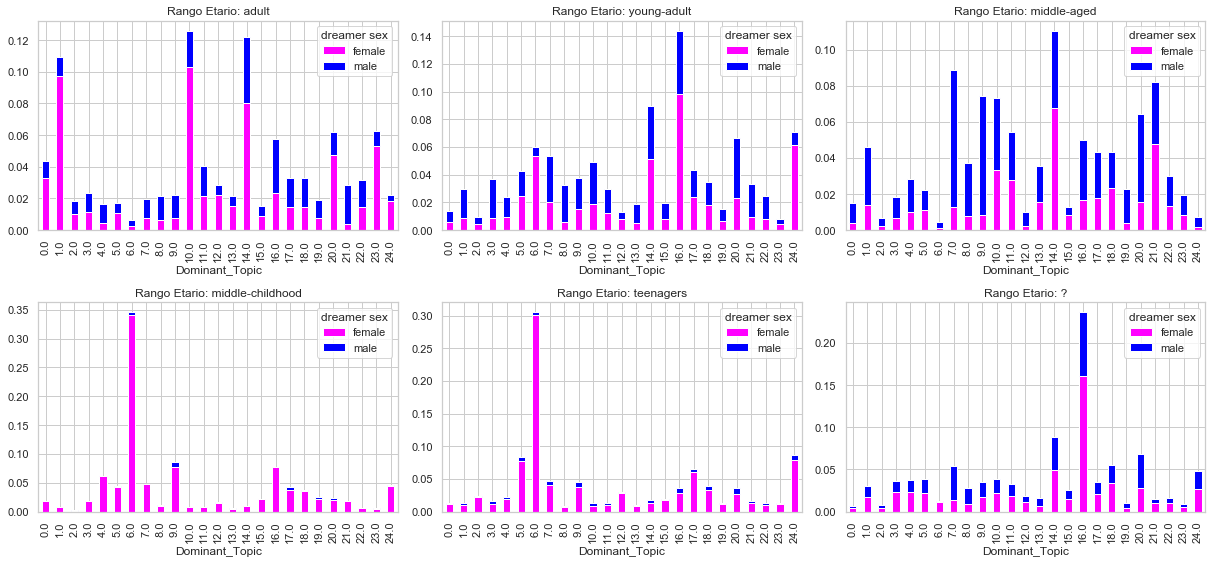

In [70]:
df_etario=df_topics[~df_topics['dreamer age'].isin(['series'])]

targets=['adult','young-adult','middle-aged','middle-childhood', 'teenagers','?']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 8))
x,y=0,0
for age in targets:
    df_age=df_etario[df_etario['dreamer age']==age]
    total=df_age['Perc_Contribution'].sum()
    df_age=df_age.groupby(['Dominant_Topic','dreamer sex']).agg({'Perc_Contribution': 'sum'})/total
    df_age.unstack()['Perc_Contribution'].plot(kind='bar',stacked=True, title=f"Rango Etario: {age}",ax=axes[x,y], color=['#FF00FF','#0000FF'])
    y=y+1
    if y==3:
        y=0
        x=x+1
fig.tight_layout()

plt.show()

[Text(0, 0.5, '?'),
 Text(0, 1.5, 'adult'),
 Text(0, 2.5, 'middle-aged'),
 Text(0, 3.5, 'middle-childhood'),
 Text(0, 4.5, 'teenagers'),
 Text(0, 5.5, 'young-adult')]

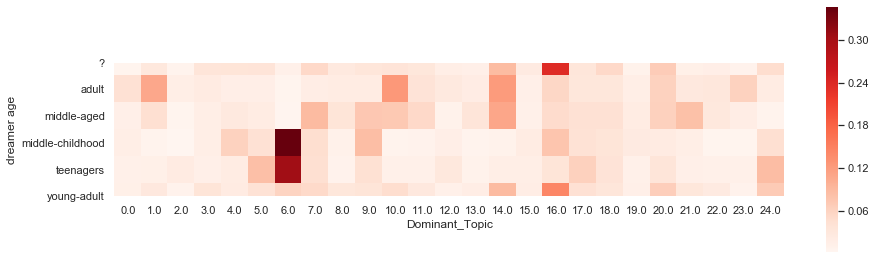

In [118]:
df_etario=df_topics[~df_topics['dreamer age'].isin(['series'])]
df_etario=df_etario.groupby(['dreamer age','Dominant_Topic']).agg({'Perc_Contribution': 'sum'})
df_etario=df_etario.unstack()['Perc_Contribution']
df_etario = df_etario.div(df_etario.sum(axis=1), axis=0)
plt.figure(figsize=(15,15))

graph=sns.heatmap(df_etario, square=True,  cbar_kws={"shrink": 0.3}, cmap=plt.cm.Reds)
graph.set_yticklabels(graph.get_yticklabels(), rotation=0, horizontalalignment='right')

In [178]:
summary[summary['dreamer age']=='?']


,group,dreamer sex,dreamer age,dream years,numbers of dreams,summary,id,total_words
10,Blind dreamers (F),female,?,mid-1990s,238,These dreams were collected in the mid-1990s from several men and women rang...,11,35883.0
11,Blind dreamers (M),male,?,mid-1990s,143,These dreams were collected in the mid-1990s from several men and women rang...,12,18701.0
24,Hall/VdC Norms: Female,female,?,1940s-1950s,490,This set contains the 500 dream reports on which Hall and Van de Castle base...,28,63757.0
25,Hall/VdC Norms: Male,male,?,1940s-1950s,491,This set contains the 500 dream reports on which Hall and Van de Castle base...,29,58325.0
36,"Izzy, uncertain dates",female,?,1997-,23,"This dream series consists of 4,352 dream reports, written down from ages 12...",40,1412.0
82,Wedding dreams,female,?,1940s-1950s & 1990s,65,This set consists of college women's dreams that involve weddings. Some were...,88,7132.0


In [73]:
summary[summary['dreamer age']=='series']

,group,dreamer sex,dreamer age,dream years,numbers of dreams,summary,id,total_words
3,Barb Sanders,female,series,1960-1997,3116,Barb Sanders (not her real name) is a middle-a...,4,576351.0
5,Barb Sanders: baseline,female,series,1960-1999,250,These 250 dreams are a representative sample o...,6,38588.0
17,Dorothea: 53 years of dreams,female,series,1912-1965,900,Dorothea lived from 1887 to 1965. This series ...,19,68185.0
18,Ed: dreams of his late wife,male,series,1980-2002,143,Ed was 57 when his wife Mary died of cancer af...,20,24562.0
21,Emma's Husband,male,series,1940-1998,72,"These dreams come from Emma's husband, who is ...",23,11912.0
22,Emma: 48 years of dreams,female,series,1949-1997,1221,Emma is an elderly woman who wrote down her dr...,24,88196.0
23,Esther: an adolescent girl,female,series,1998,110,This series is unique in that it starts at age...,25,9549.0
26,"Izzy (ALL, including non-consecutive)",female,series,2003-2016,4352,"This dream series consists of 4,352 dream repo...",30,593077.0
27,Izzy (all),female,series,2003-2016,4329,"This dream series consists of 4,352 dream repo...",31,591665.0
37,"Jasmine (ALL, including non-consecutive)",female,series,1999-2011,664,Jasmine is a young woman who recorded hundreds...,41,227743.0


## Vietnam y Phil

In [ ]:
df_vietnam = df.loc[df['group'].isin(['Vietnam Vet: 1970-2008 war dreams', 'Vietnam Vet: 2015 dreams', 'Vietnam Vet: 2016-17 dreams'])]
df_phil = df.loc[df['group'].isin(['Phil 1: teens', 'Phil 2: late 20s', 'Phil 3: retirement'])]
df_pegasus = df.loc[df['group'].isin(['Pegasus: a factory worker'])]
df_norman = df.loc[df['group'].isin(['Norman: a child molester'])]

print(f"Se cuenta con {len(df_vietnam)} sueños de Vietnam. El corpus tiene {int(df_vietnam['words'].sum())} palabras.")
print(f"Se cuenta con {len(df_phil)} sueños de Phil, nuestro conjunto de control. El corpus tiene {int(df_phil['words'].sum())} palabras.")
print(f"Se cuenta con {len(df_pegasus)} sueños de Pegasus. El corpus tiene {int(df_pegasus['words'].sum())} palabras.")
print(f"Se cuenta con {len(df_norman)} sueños de Norman, nuestro conjunto de control. El corpus tiene {int(df_norman['words'].sum())} palabras.")

### NMF solo con hasta 15 topicos

In [ ]:
number_of_topics_list_nmf = [10,15]
print("Applying NMF topic modelling ...")
t0 = time()
nmf_model_dict = {}
for num_topics in number_of_topics_list_nmf:
    print(f"Looking for {num_topics} topics ...")
    t1 = time()
    nmf_model = gensim.models.nmf.Nmf(corpus=corpus,
                                id2word=id2word,
                                num_topics=num_topics, 
                                random_state=100,
                                eval_every=5,
                                chunksize=10,
                                passes=10,
                                kappa=0.1)
    nmf_model_dict[num_topics] = nmf_model
    print(f"... done in {time() - t1}s for {num_topics} topics.")

print(f"... all done in {time() - t0}s.")

In [ ]:
list_of_topics = []
for topic_distribution in nmf_model_dict[10][corpus[:]]:
    sorted_topics = sorted(topic_distribution, key=lambda x: (x[1]), reverse=True)
    try:
        list_of_topics.append(sorted_topics[0][0])
    except:
        list_of_topics.append(-1)

topics_df = pd.DataFrame(list_of_topics, columns=['topic_number'])
print("--------------------------------------------")
topics_df['topic_number'].value_counts()

In [ ]:
topics = [[word for word, prob in topic] for topicid, topic in nmf.show_topics(formatted=False)]
#cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, coherence='u_mass')
cm = CoherenceModel(topics=topics, texts=data_ready, dictionary=id2word, coherence='c_npmi')
print(f"Coherende per topic {cm.get_coherence_per_topic()}")
print(f"Coherence total {cm.get_coherence()}")

In [ ]:
corpus_freqs = collections.Counter(itertools.chain.from_iterable(data_ready))
doc_freqs = collections.Counter(itertools.chain.from_iterable(set(doc) for doc in data_ready))
missing = [token for token in corpus_freqs if corpus_freqs[token] == 10 and token not in id2word.id2token]
[(token, corpus_freqs[token], doc_freqs[token]) for token in missing]